# Reproducing d12 using moment maps and investigating the relasionship between moments and observables

In [1]:
#all imports:
import numpy as np
import pylab
pylab.rcParams['figure.figsize'] = 12, 16
import healpy as hp
import pysm3
import pysm3.units as u
from matplotlib.backends.backend_pdf import PdfPages
import sympy as sym
import scipy.constants as constants
import matplotlib
import pymaster as nmt
#lib for 3D moments:
import funclib as lib
import seaborn as sns
import pandas as pd
plt.rcParams['font.family'] = 'sans-serif'  


In [2]:
def compute_pure3Dmom(nside,model,betamap,tempmap,maxborder=3,maxtorder=3):
    npix = hp.nside2npix(nside)

    mom = np.zeros([2,maxborder+1,maxtorder+1,npix],dtype='complex128')
    betabar = np.zeros(npix)
    b_Tbar = np.zeros(npix)
    betabari = np.zeros(npix)
    b_Tbari= np.zeros(npix) 
    alisti = model[:,0]
    alist = model[:,1] + model[:,2]*1j
    betalist=betamap
    b_Tlist=1/tempmap
    betabar = np.real(np.sum(betalist*alist)/np.sum(alist))
    b_Tbar = np.real(np.sum(b_Tlist*alist)/np.sum(alist))
    betabari = np.sum(betalist*alisti)/np.sum(alisti)
    b_Tbari = np.sum(b_Tlist*alisti)/np.sum(alisti)

    if maxtorder>=maxborder:
        for border in range(maxborder+1):
            for torder in range(maxtorder+1-border):
                if (border == 0)  * (torder == 0) == 1:
                    mom[0,0,0] = np.ones(npix)  
                    mom[1,0,0] = np.ones(npix) 
                else:
                    mom[0,border,torder] = np.sum(alisti*(betalist-betabari)**border*(b_Tlist-b_Tbari)**torder,axis=0)/np.sum(alisti,axis=0)
                    mom[1,border,torder] = np.sum(alist*(betalist-betabar)**border*(b_Tlist-b_Tbar)**torder,axis=0)/np.sum(alist,axis=0)
    else:
        for torder in range(maxtorder+1):
            for border in range(maxborder+1-torder):
                if (border == 0)  * (torder == 0) == 1:
                    mom[0,0,0] = np.ones(npix)   
                    mom[1,0,0] = np.ones(npix)   
                else:
                    mom[0,border,torder] = np.sum(alisti*(betalist-betabari)**border*(b_Tlist-b_Tbari)**torder,axis=0)/np.sum(alisti,axis=0)
                    mom[1,border,torder] = np.sum(alist*(betalist-betabar)**border*(b_Tlist-b_Tbar)**torder,axis=0)/np.sum(alist,axis=0)
    return mom, betabari, betabar, b_Tbari, b_Tbar

def model_mbb_moments(nside,nu,model,mom,tempmap,nu0=353.,maxborder=3,maxtorder=3,nside_moments=512,mult_factor=1.,tempmapP=np.zeros(1),quiet=True):
    npix_moments = hp.nside2npix(nside_moments)
    map3D = np.zeros([3,npix_moments])
    
    #tempmap= 1/tempmap
    #tempmapP= 1/tempmapP
    beta = sym.Symbol('ß')
    b_T = sym.Symbol('ß_T')
    
    nuval = nu * 1e9
    nu0val = nu0 * 1e9
    Bval = 2*constants.h*(nuval**3)/constants.c**2
    Cval = constants.h*nuval/constants.k
    Bval0 = 2*constants.h*(nu0val**3)/constants.c**2
    Cval0 = constants.h*nu0val/constants.k
    Bvalratio = Bval/Bval0
    mbb = ((nuval / nu0val) ** beta) * Bvalratio / (sym.exp(Cval*b_T) - 1) * (sym.exp(Cval0*b_T) - 1)
    if maxtorder>=maxborder:
        for border in range(maxborder+1):
            for torder in range(maxtorder+1-border):
                if quiet==False:
                    print((border,torder))
                analyticalmom = sym.diff(mbb,beta,border)*sym.diff(mbb,b_T,torder).factor()/mbb**2
            
                if torder == 0:
                    valuemomi = float(analyticalmom)
                    valuemomP = valuemomi
                else:
                    if tempmapP.any()==False:
                        analyticalmom = sym.lambdify(b_T,analyticalmom,'numpy')
                        valuemomi = analyticalmom(1/tempmap)
                        valuemomP = valuemomi
                    else:
                        analyticalmom = sym.lambdify(b_T,analyticalmom,'numpy')
                        valuemomi = analyticalmom(1/tempmap)
                        valuemomP = analyticalmom(1/tempmapP)
                if ((border == 0)  * (torder == 0)) == 1:
                    modelcomplex = (model[1]+1j*model[2]) * 1./(np.math.factorial(border)*np.math.factorial(torder))*mom[1,border,torder]*valuemomP
                    map3D[0] += model[0] * 1./(np.math.factorial(border)*np.math.factorial(torder))*np.real(mom[0,border,torder])*valuemomi
                else:
                    modelcomplex = (model[1]+1j*model[2]) * mult_factor/(np.math.factorial(border)*np.math.factorial(torder))*mom[1,border,torder]*valuemomP
                    map3D[0] += model[0] * mult_factor/(np.math.factorial(border)*np.math.factorial(torder))*np.real(mom[0,border,torder])*valuemomi
                map3D[1] += np.real(modelcomplex)
                map3D[2] += np.imag(modelcomplex)
    else:
        for torder in range(maxtorder+1):
            for border in range(maxborder+1-torder):
                if quiet==False:
                    print((border,torder))
                analyticalmom = sym.diff(mbb,beta,border)*sym.diff(mbb,b_T,torder).factor()/mbb**2
            
                if torder == 0:
                    valuemomi = float(analyticalmom)
                    valuemomP = valuemomi
                else:
                    if tempmapP.any()==False:
                        analyticalmom = sym.lambdify(b_T,analyticalmom,'numpy')
                        valuemomi = analyticalmom(1/tempmap)
                        valuemomP = valuemomi
                    else:
                        analyticalmom = sym.lambdify(b_T,analyticalmom,'numpy')
                        valuemomi = analyticalmom(1/tempmap)
                        valuemomP = analyticalmom(1/tempmapP)
                if ((border == 0)  * (torder == 0)) == 1:
                    modelcomplex = (model[1]+1j*model[2]) * 1./(np.math.factorial(border)*np.math.factorial(torder))*mom[1,border,torder]*valuemomP
                    map3D[0] += model[0] * 1./(np.math.factorial(border)*np.math.factorial(torder))*np.real(mom[0,border,torder])*valuemomi
                else:
                    modelcomplex = (model[1]+1j*model[2]) * mult_factor/(np.math.factorial(border)*np.math.factorial(torder))*mom[1,border,torder]*valuemomP
                    map3D[0] += model[0] * mult_factor/(np.math.factorial(border)*np.math.factorial(torder))*np.real(mom[0,border,torder])*valuemomi
                map3D[1] += np.real(modelcomplex)
                map3D[2] += np.imag(modelcomplex)
    if nside != nside_moments: map3D = hp.ud_grade(map3D,nside)
    return map3D


# Create d12 map, compute its moments and approximate it with a moment expansion

In [3]:
#general keywords
nside = 512
npix =hp.nside2npix(nside)
Pathsave='./plots/'
instr='Planck'
Pathload='./maps/'
fgtype='d10'
omax=10 #maximum order at which to compute the moments
if fgtype[0]=='d':
    model_type='mbb'
elif fgtype[0]=='s':
    model_type='PL'

#pick frequencies
if instr=='Planck':
    freq=np.array([100,143,217,353])
if instr=='LiteBIRD':
    freq=np.array([ 40.,  50.,  60.,  68.,  78.,  89., 100., 119., 140., 166., 195.,235., 280., 337., 402.])

#Generate d12 map at instrument frequencies
sky = pysm3.Sky(nside=nside, preset_strings=[fgtype])
model = np.array([sky.get_emission(freq[f] * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freq[f]*u.GHz)).value for f in range(len(freq))])

if model_type=='mbb':
    dust = sky.components[0]
    if fgtype=="d12":
        betamap= dust.mbb_index.value
        tempmap= dust.mbb_temperature.value
        nu0=dust.freq_ref.value
        AI = dust.layers.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value
    else:
        nu0=dust.freq_ref_P.value
        betamap= np.array([dust.mbb_index.value])
        tempmap= np.array([dust.mbb_temperature.value])
        AI = np.array([dust.get_emission(nu0 * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value])
elif model_type=='PL':
    sync = sky.components[0]
    nu0=sync.freq_ref_P.value
    betamap= np.array([sync.pl_index.value])
    AI = np.array([sync.get_emission(nu0 * u.GHz).to(u.uK_CMB, equivalencies=u.cmb_equivalencies(nu0*u.GHz)).value])

mom, barbI, barbP, bartI, bartP = compute_pure3Dmom(nside,AI,betamap,tempmap,maxborder=omax,maxtorder=omax)
    

In [4]:
#build the SED of the model from the moment maps
Abar=np.sum(AI,axis=0)
barMBBI = lib.MBBpysm(freq,Abar[0],barbI,bartI,nu0)
barMBBP = lib.MBBpysm(freq,Abar[1]+1j*Abar[2],barbP,bartP,nu0)
barMBB=np.array([barMBBI,barMBBP.real,barMBBP.imag])

#compute d12 using moment expansion at 100 GHz 
f = 100 #GHz
idf=list(freq).index(f)

#compute the maps for the expansion up to order omax:
modelmoms= np.zeros((omax+1,3,npix))
modelmoms[0]= barMBB[:,idf]
for i in range(omax):
    modelmoms[i+1]= model_mbb_moments(nside,f, barMBB[:,idf],mom,1/bartI,maxborder=(i+1),maxtorder=(i+1),tempmapP=1/bartP)

# Computing residuals
Compare moment expansion and d12 at different orders

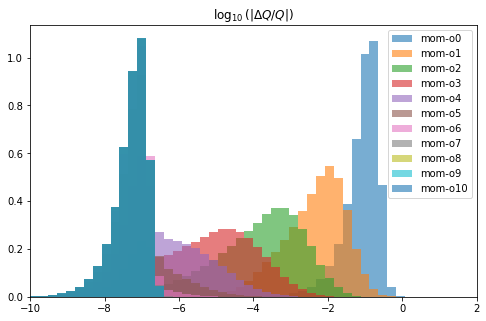

In [5]:
#simple histograms of residuals

pol = 1 #0,1,2=I,Q,U
labelpol=["I","Q","U"]
ranged=[-10,2] #range of the powers of 10
plt.figure(figsize=(8,5))
for i in range(omax+1):
    plt.hist(np.log10(abs((model[idf,pol]-modelmoms[i,pol])/modelmoms[i,pol])),label=r'mom-o%s'%i,bins=50,alpha=0.6,density=True,range=ranged)#,weights=np.ones(51)/188241.46)
plt.xlim(ranged)
plt.title(r"$\log_{10}(|\Delta %s/%s|)$"%(labelpol[pol],labelpol[pol]))
plt.legend()
plt.show()

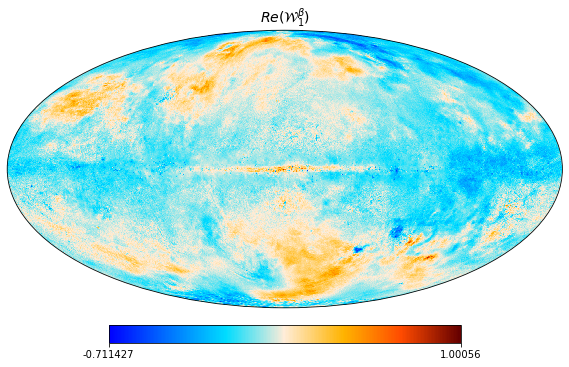

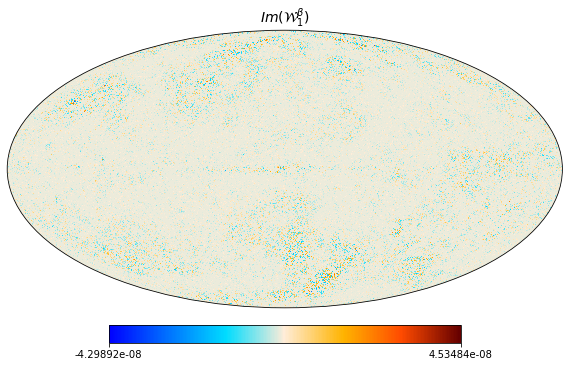

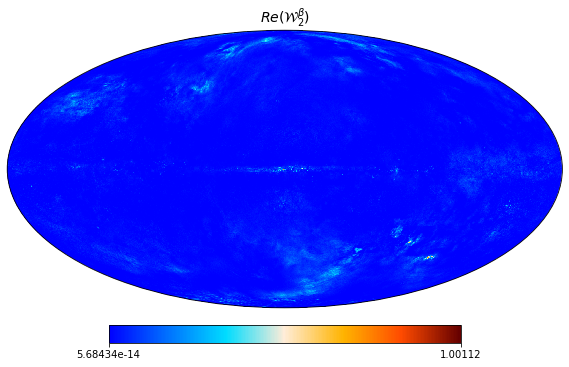

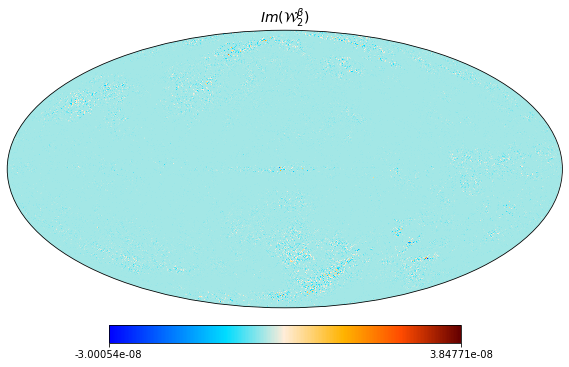

In [6]:
hp.projview(mom[1,1,0].real, cmap='planck', title=r'$Re(\mathcal{W}_1^\beta)$')#min=-0.1, max=0.1)
plt.show()

hp.projview(mom[1,1,0].imag, cmap='planck', title=r'$Im(\mathcal{W}_1^\beta)$')#min=0, max=0.01
plt.show()

hp.projview(mom[1,2,0].real, cmap='planck', title=r'$Re(\mathcal{W}_2^\beta)$')#min=0, max=0.1,
plt.show()

hp.projview(mom[1,2,0].imag, cmap='planck', title=r'$Im(\mathcal{W}_2^\beta)$')#min=0, max=0.01,
plt.show()

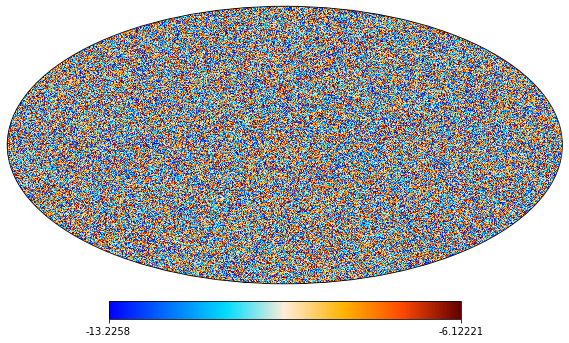

In [10]:
a=np.log10(abs((model[idf,pol]-modelmoms[omax,pol])/modelmoms[i,pol]))
hp.projview(a, cmap='planck',norm='hist')#,min=-3, max=-1)

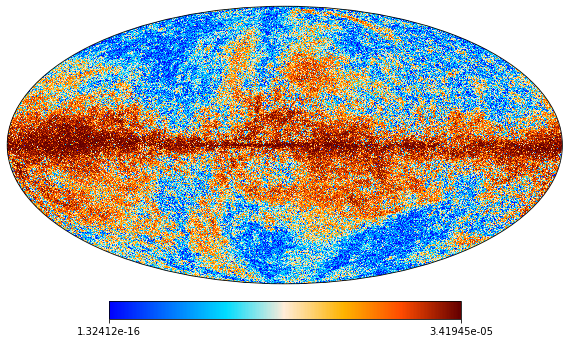

In [8]:
sigpixlb= 0.8612084011610828
hp.projview(abs(model[idf,pol]-modelmoms[omax,pol])/sigpixlb, cmap='planck',norm='hist')#min=0, max=0.01,


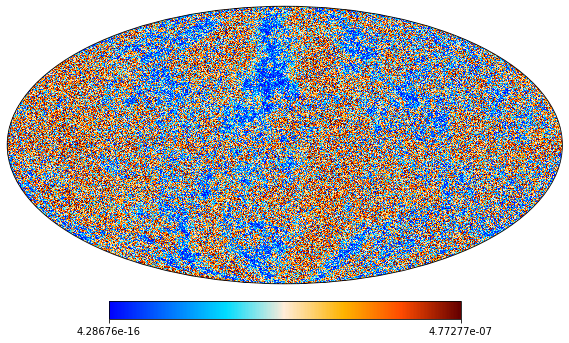

In [9]:
hp.projview(abs((model[idf, pol] - modelmoms[omax,pol])/abs(model[idf, 1]+1j*model[idf, 2])), cmap='planck',norm='hist')#min=0, max=0.01,
